In [ ]:
import wikipedia as wiki
import pandas as pd
import re
from flair.models import TextClassifier
from flair.data import Sentence
from segtok.segmenter import split_single
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# Sentiment Analysis

In [8]:
woman = wiki.page("Woman")
female = wiki.page("Femaless")
femininity = wiki.page("Femininity")
feminism = wiki.page("Feminism")
nb = wiki.page("Non-binary gender")
man = wiki.page("Mann")
male = wiki.page("MALES")
masculinity = wiki.page("Masculinity")

In [9]:
womantext = woman.content
femaletext = female.content
femininitytext = femininity.content
feminismtext = feminism.content
nbtext = nb.content
mantext = man.content
maletext = male.content
masculinitytext = masculinity.content

## Flair

In [ ]:
classifier = TextClassifier.load('en-sentiment')

In [ ]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    
     # Remove headlines
    result = re.sub("==[^=]*==", '', result)

    # Fix sentence spacing
    result = re.sub(r'\.([A-Z])', r'. \1', result)
    
    return result

In [ ]:
def make_sentences(text):
    """ Break apart text into a list of sentences """
    cleaned_text = text.replace("=", "")
    sentences = [sent for sent in split_single(cleaned_text) if sent.strip()]
    return sentences

In [ ]:
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    if hasattr(text, 'labels') and len(text.labels) > 0:
        label = text.labels[0]
        value = label.value
        score = label.score
        if value == 'POSITIVE':
            result = score
        else:
            result = -score
        return round(result, 3)
    else:
        # Handle case where no prediction was made
        return 0

In [ ]:
def get_scores(sentences):
    """ Call predict on every sentence of a text """
    results = []
    
    for i in range(0, len(sentences)): 
        results.append(predict(sentences[i]))
    return results

def get_sum(scores):
    
    result = round(sum(scores), 3)
    return result

In [ ]:
data = {'Gender': ["Man", "Woman", "Non Binary"], 'text': [mantext, womantext, nbtext]}
df = pd.DataFrame(data=data)
df = df.dropna()
df = df.reset_index(drop=True)
df.text = df.text.apply(clean)
df['sentences'] = df.text.apply(make_sentences)
df['scores'] = df['sentences'].apply(get_scores)
df['scores_sum'] = df.scores.apply(get_sum)
df['scores_avg'] = df.apply(lambda row: row['scores_sum'] / len(row['scores']), axis=1)

In [ ]:
df

## Investigating Judgements

In [ ]:
# Get the first row of the dataframe
row = df.iloc[0]

# Get the sentences and scores from the row
sentences = row['sentences']
scores = row['scores']

# Find the indices of the negative scores
negative_indices = [i for i, score in enumerate(scores) if score < 0]

# Get the sentences with negative scores and their respective scores
negative_sentences = [sentences[i] for i in negative_indices]
negative_scores = [scores[i] for i in negative_indices]

# Print out the sentences with negative scores and their respective scores
for sentence, score in zip(negative_sentences, negative_scores):
    print(f"{sentence} (score: {score})")

In [ ]:
def sentiment_analysis(gender):
    df_gender = df[df['Gender'] == gender]
    neg = 0
    neu = 0
    pos = 0
    for scores in df_gender['scores']:
        for score in scores:
            if score <= -0.2:
                neg += 1
            elif score >= 0.2:
                pos += 1
            else:
                neu += 1
    total = neg + neu + pos
    neg_percent = round((neg / total) * 100, 1)
    neu_percent = round((neu / total) * 100, 1)
    pos_percent = round((pos / total) * 100, 1)
    
    print(f"Overall sentiment dictionary is : {{'neg': {neg_percent/100}, 'neu': {neu_percent/100}, 'pos': {pos_percent/100}}}")
    print(f"Text was rated as {neg_percent} % Negative")
    print(f"Text was rated as {neu_percent} % Neutral")
    print(f"Text was rated as {pos_percent} % Positive")
    
    if neg_percent > pos_percent:
        print("Text Overall Rated As Negative")
    elif pos_percent > neg_percent:
        print("Text Overall Rated As Positive")
    else:
        print("Text Overall Rated As Neutral")

In [ ]:
sentiment_analysis("Man")

In [ ]:
sentiment_analysis("Woman")

In [ ]:
sentiment_analysis("Non Binary")

## Affin

In [ ]:
afn = Afinn()

In [ ]:
data = {'Gender': ["Man", "Male", "Masculinity", "Woman", "Female", "Femininity", "Feminism", "Non Binary"], 'text': [mantext, maletext, masculinitytext, womantext, femaletext, femininitytext, feminismtext, nbtext]}
df = pd.DataFrame(data=data)
df.text = df.text.apply(clean)
df['sentences'] = df.text.apply(make_sentences)

In [ ]:
# compute scores (polarity) and labels
scores = []
positive_percentages = []
negative_percentages = []
neutral_percentages = []
for index, row in df.iterrows():
    row_scores = [afn.score(sentence) for sentence in row['sentences']]
    scores.append(row_scores)
    
    sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in row_scores]
    positive_percentage = sentiments.count('positive') / len(sentiments)
    negative_percentage = sentiments.count('negative') / len(sentiments)
    neutral_percentage = sentiments.count('neutral') / len(sentiments)
    
    positive_percentages.append(positive_percentage)
    negative_percentages.append(negative_percentage)
    neutral_percentages.append(neutral_percentage)

# add new columns to the dataframe
df['scores'] = scores
df['positive_percentage'] = positive_percentages
df['negative_percentage'] = negative_percentages
df['neutral_percentage'] = neutral_percentages

In [ ]:
df

In [ ]:
df.iloc[1]["sentences"]

## Generating Output

In [ ]:
def generate_sentiment_report(df, gender):
    # filter rows by gender
    df = df[df['Gender'] == gender]
    
    # calculate overall sentiment percentages
    total_positive_percentage = df['positive_percentage'].mean()
    total_negative_percentage = df['negative_percentage'].mean()
    total_neutral_percentage = df['neutral_percentage'].mean()
    
    # create sentiment dictionary
    sentiment_dict = {
        'neg': round(total_negative_percentage, 3),
        'neu': round(total_neutral_percentage, 3),
        'pos': round(total_positive_percentage, 3)
    }
    
    # generate report
    report = f"Overall sentiment dictionary for gender {gender} is : {sentiment_dict}\n"
    report += f"Text was rated as {round(sentiment_dict['neg']*100, 1)} % Negative\n"
    report += f"Text was rated as {round(sentiment_dict['neu']*100, 1)} % Neutral\n"
    report += f"Text was rated as {round(sentiment_dict['pos']*100, 1)} % Positive\n"
    
    if sentiment_dict['pos'] > sentiment_dict['neg']:
        report += f"Text Overall Rated As Positive for gender {gender}"
    elif sentiment_dict['pos'] < sentiment_dict['neg']:
        report += f"Text Overall Rated As Negative for gender {gender}"
    else:
        report += f"Text Overall Rated As Neutral for gender {gender}"
    
    return report

In [ ]:
print(generate_sentiment_report(df, 'Man'))

In [ ]:
print(generate_sentiment_report(df, 'Woman'))

In [ ]:
print(generate_sentiment_report(df, 'Non Binary'))

In [ ]:
print(generate_sentiment_report(df, 'Male'))

In [ ]:
print(generate_sentiment_report(df, 'Female'))

In [ ]:
print(generate_sentiment_report(df, 'Femininity'))

In [ ]:
print(generate_sentiment_report(df, 'Feminism'))

In [ ]:
print(generate_sentiment_report(df, 'Masculinity'))

## Split into Sections

In [ ]:
def clean_and_split(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub('\n', '', result)
    result = re.sub(r'\.([A-Z])', r'. \1', result)

    # Split text according to headlines
    split_text = re.split(r'==\s(.+?)\s==', result)

    # Create list of tuples
    tuples_list = []

    # Assign "Introduction" as the headline for the first paragraph
    if len(split_text) > 0:
        introduction_text = make_sentences(split_text[0])
        tuples_list.append(("Introduction", introduction_text))

    # Filter out unwanted sections
    unwanted_sections = ["See also", "References", "Further reading", "External links", "Explanatory notes"]
    for i in range(1, len(split_text), 2):
        headline = split_text[i]
        text = split_text[i + 1] if i + 1 < len(split_text) else ''
        if headline not in unwanted_sections:
            sentences = make_sentences(text)
            tuples_list.append((headline, sentences))
        
    return tuples_list

In [ ]:
data = {'Gender': ["Man", "Male", "Masculinity", "Woman", "Female", "Femininity", "Feminism", "Non Binary"], 'text': [mantext, maletext, masculinitytext, womantext, femaletext, femininitytext, feminismtext, nbtext]}
df = pd.DataFrame(data=data)
df.text = df.text.apply(clean_and_split)

In [ ]:
df.iloc[1]["text"]

In [ ]:
# Create empty lists to store the results
gender_list = []
headline_list = []
sentences_list = []
scores_list = []
positive_percentages = []
negative_percentages = []
neutral_percentages = []

# Iterate over the rows in the dataframe
for index, row in df.iterrows():
    gender = row['Gender']
    text_tuples = row['text']
    
    # Iterate over the paragraphs in the text
    for headline, sentences in text_tuples:
        # Compute scores and sentiments for each paragraph
        paragraph_scores = [afn.score(sentence) for sentence in sentences]
        paragraph_sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in paragraph_scores]
        
        if paragraph_sentiments:
            positive_percentage = paragraph_sentiments.count('positive') / len(paragraph_sentiments)
            negative_percentage = paragraph_sentiments.count('negative') / len(paragraph_sentiments)
            neutral_percentage = paragraph_sentiments.count('neutral') / len(paragraph_sentiments)
        else:
            positive_percentage = 0
            negative_percentage = 0
            neutral_percentage = 0
        
        # Append the data to the lists
        gender_list.append(gender)
        headline_list.append(headline)
        sentences_list.append(sentences)
        scores_list.append(paragraph_scores)
        positive_percentages.append(positive_percentage)
        negative_percentages.append(negative_percentage)
        neutral_percentages.append(neutral_percentage)

# Create a new dataframe
new_df = pd.DataFrame({
     'Gender': gender_list,
    'Headline': headline_list,
    'sentences': sentences_list,
    'scores': scores_list,
    'positive_percentage': positive_percentages,
    'negative_percentage': negative_percentages,
    'neutral_percentage': neutral_percentages
})

# Reset the index of the new dataframe
new_df.reset_index(drop=True, inplace=True)

In [ ]:
new_df

In [ ]:
def fuse_rows_by_headline(dataframe, gender, major_headlines):
    fused_data = []
    fuse_flag = False
    fused_sentences = []
    fused_headline = ""
    scores = []
    
    for index, row in dataframe.iterrows():
        if row['Gender'] == gender:
            if row['Headline'] in major_headlines:
                if fuse_flag:
                    fused_data.append([gender, fused_headline, fused_sentences, scores])
                    fused_sentences = []
                    fused_headline = ""
                    scores = []
                
                fuse_flag = True
                fused_headline = row['Headline']
                fused_sentences.extend(row['sentences'])
                scores.extend(row['scores'])
            elif fuse_flag:
                fused_sentences.extend(row['sentences'])
                scores.extend(row['scores'])
    
    if fuse_flag:
        fused_data.append([gender, fused_headline, fused_sentences, scores])
    
    fused_df = pd.DataFrame(fused_data, columns=['Gender', 'Headline', 'text', 'scores'])
    
    # Recalculate percentages
    positive_percentages = []
    negative_percentages = []
    neutral_percentages = []
    
     for row in fused_df.iterrows():
        sentiments = ['positive' if score > 0 else 'negative' if score < 0 else 'neutral' for score in row[1]['scores']]
        positive_percentage = sentiments.count('positive') / len(sentiments)
        negative_percentage = sentiments.count('negative') / len(sentiments)
        neutral_percentage = sentiments.count('neutral') / len(sentiments)
        
        positive_percentages.append(positive_percentage)
        negative_percentages.append(negative_percentage)
        neutral_percentages.append(neutral_percentage)
    
    fused_df['positive_percentage'] = positive_percentages
    fused_df['negative_percentage'] = negative_percentages
    fused_df['neutral_percentage'] = neutral_percentages
    
    return fused_df

In [ ]:
gender = 'Female'
major_headlines = ['Introduction', 'Etymology and usage', 'Defining characteristics', 'Females across species', 'Evolution', 'Symbol']

female_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [ ]:
female_df

In [ ]:
gender = 'Male'
major_headlines = ['Introduction', 'Overview', 'Evolution', 'Symbol and usage', 'Males across species', 'Sex determination', 'Secondary sex characteristics']

male_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [ ]:
male_df

In [ ]:
gender = 'Man'
major_headlines = ['Introduction', 'Etymology', 'Biology', 'Reproductive system', 'Sexuality and gender', 'Social role', 'History', 'Family', 'Work', 'Entertainment and media', 'Clothing', 'Education', 'Rights', 'Sex symbol']

man_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [ ]:
man_df

In [ ]:
gender = 'Woman'
major_headlines = ['Introduction', 'Etymology', 'Terminology', 'Biology', 'Health', 'Reproductive rights and freedom', 'Culture and gender roles', 'History', 'Clothing, fashion and dress codes', 'Fertility and family life', 'Religion', 'Education', 'Women in politics', 'Science, literature and art', 'Gender symbol', 'Femininity']

woman_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [ ]:
woman_df

In [ ]:
gender = 'Non Binary'
major_headlines = ['Introduction', 'Terms, definitions, and identities', 'History', 'Pronouns and titles', 'Legal recognition', 'Discrimination', 'Symbols and observances', 'Population figures']

nb_df = fuse_rows_by_headline(new_df, gender, major_headlines)

In [ ]:
nb_df

## Vader

In [ ]:
# function to print sentiments of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("Text was rated as ", round(sentiment_dict['neg']*100,2), "% Negative")
    print("Text was rated as ", round(sentiment_dict['neu']*100,2), "% Neutral")
    print("Text was rated as ", round(sentiment_dict['pos']*100,2), "% Positive")
 
    print("Text Overall Rated As", end = " ")
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
 
    else :
        print("Neutral")

In [ ]:
sentiment_scores(mantext)

In [ ]:
sentiment_scores(womantext)

In [ ]:
sentiment_scores(nbtext)
#pc? reason for high neutrality

In [ ]:
sentiment_scores(maletext)

In [ ]:
sentiment_scores(femaletext)

In [ ]:
sentiment_scores(femininitytext)

In [ ]:
sentiment_scores(feminismtext)

In [ ]:
sentiment_scores(masculinitytext)

# Backlink Analysis

In [ ]:
backlinks = pd.read_excel("Backlink.xlsx",sheet_name='2')

In [ ]:
backlinks.head()

In [ ]:
model = smf.glm(formula = "count ~ gender", data=backlinks, family=sm.families.NegativeBinomial()).fit()

model.summary()

# Linking patterns

In [4]:
sparql = SPARQLWrapper("http://dbpedia.org/sparql")  # DBpedia SPARQL endpoint

man_uri = "http://dbpedia.org/resource/Man"  
woman_uri = "http://dbpedia.org/resource/Woman"
male_uri =  "http://dbpedia.org/resource/Male"
female_uri = "http://dbpedia.org/resource/Female"
non_binary_uri = "http://dbpedia.org/resource/Non-binary_gender"

In [42]:
# print('Calculate the Input domains per node in a directed graph:')

def input_domain(G):
    node_2_input_domain = {node: len(nx.ancestors(G, node)) for node in G.nodes}
    return node_2_input_domain
                                     
# print(input_domain(graph))

def proximity_prestige(G):
    # Calculate fraction of all vertices that are in i's input domain
    node_2_inp_domain = input_domain(G)
    node_2_frac_input_domain = {node: inp_domain/len(G.nodes) for node, inp_domain in node_2_inp_domain.items()}
    
    # Calculate average distance from i to vertex in input domain
    node_2_avg_distance = {}
    for node in G.nodes:
        shortest_path_lengths = [nx.shortest_path_length(G, source=ancestor, target=node) for ancestor in nx.ancestors(G, node)]
        if len(shortest_path_lengths) > 0:
            node_2_avg_distance[node] = sum(shortest_path_lengths)/len(shortest_path_lengths)
        else:
            node_2_avg_distance[node] = 0
    
    #Calculate proximity prestige per node
    node_2_proximity_prestige = {}
    for node in node_2_frac_input_domain:
        if node_2_avg_distance[node] > 0:
            node_2_proximity_prestige[node] = node_2_frac_input_domain[node]/node_2_avg_distance[node]
        else:
            node_2_proximity_prestige[node] = 0
    
    return node_2_proximity_prestige

# print('Calculate the proximity prestige per node in a directed graph:')
# print(proximity_prestige(graph))

# print('Calculate the PageRank per node in a directed graph:')
# print(nx.pagerank(graph))

## Man

In [45]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % man_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_man = sparql.query().convert()

# Create an empty directed graph
graph_man = nx.DiGraph()

# Add 'Man' page to the graph
graph_man.add_node(man_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_man["results"]["bindings"]:
    link = result["link"]["value"]
    graph_man.add_edge(man_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_man = sparql.query().convert()

    # Add the linked page to the graph
    graph_man.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_man["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_man.nodes():
            graph_man.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

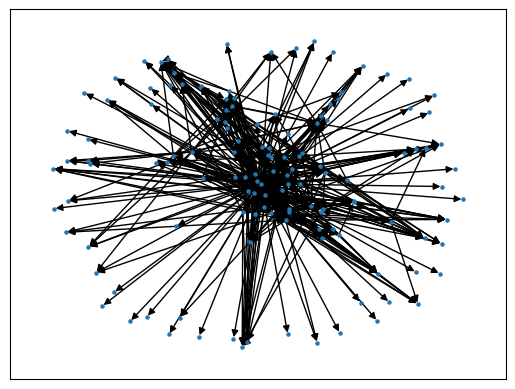

In [70]:
nx.draw_networkx(graph_man, with_labels = False, node_size = 5)

In [47]:
print(f"number of nodes: {graph_man.number_of_nodes()}")
print(f"number of edges: {graph_man.number_of_edges()}")

number of nodes: 131
number of edges: 464


In [48]:
#Degree scores
top_degree_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_man

Top degree scores:


{'http://dbpedia.org/resource/Man': 1.0846153846,
 'http://dbpedia.org/resource/Gender_role': 0.1692307692,
 'http://dbpedia.org/resource/Woman': 0.1615384615,
 "http://dbpedia.org/resource/Men's_rights_movement": 0.1538461538,
 'http://dbpedia.org/resource/Human': 0.1461538462,
 'http://dbpedia.org/resource/Male': 0.1461538462,
 'http://dbpedia.org/resource/Reproductive_system': 0.1461538462,
 'http://dbpedia.org/resource/Puberty': 0.1307692308,
 'http://dbpedia.org/resource/Mammal': 0.1307692308,
 'http://dbpedia.org/resource/Female': 0.1307692308}

In [49]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_man

Top betweeness scores:


{'http://dbpedia.org/resource/Man': 0.3978996176,
 'http://dbpedia.org/resource/Human': 0.2008348241,
 'http://dbpedia.org/resource/Gender_role': 0.0723191924,
 'http://dbpedia.org/resource/Mammal': 0.0251392793,
 'http://dbpedia.org/resource/Culture': 0.0231883749,
 'http://dbpedia.org/resource/Male': 0.0190042214,
 'http://dbpedia.org/resource/Misogyny': 0.0183284351,
 "http://dbpedia.org/resource/Men's_studies": 0.0156003493,
 'http://dbpedia.org/resource/Circumcision': 0.0155919016,
 'http://dbpedia.org/resource/Alcohol_(drug)': 0.0155488353}

In [85]:
top_prestige_scores_man = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_man).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_man

Top prestige scores:


{'http://dbpedia.org/resource/Puberty': 0.2557251908,
 'http://dbpedia.org/resource/Human': 0.2310653833,
 'http://dbpedia.org/resource/Man': 0.2092324337,
 'http://dbpedia.org/resource/DNA': 0.1930072566,
 'http://dbpedia.org/resource/Uterus': 0.1905516347,
 'http://dbpedia.org/resource/Mammal': 0.1898037077,
 'http://dbpedia.org/resource/Müllerian_duct': 0.1875110953,
 'http://dbpedia.org/resource/Carl_Linnaeus': 0.1856818651,
 'http://dbpedia.org/resource/Gender_identity': 0.1819928214,
 'http://dbpedia.org/resource/Prostate': 0.1786451582}

## Woman

In [28]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % woman_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_woman = sparql.query().convert()

# Create an empty directed graph
graph_woman = nx.DiGraph()

# Add 'Man' page to the graph
graph_woman.add_node(woman_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_woman["results"]["bindings"]:
    link = result["link"]["value"]
    graph_woman.add_edge(woman_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_woman = sparql.query().convert()

    # Add the linked page to the graph
    graph_woman.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_woman["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_woman.nodes():
            graph_woman.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

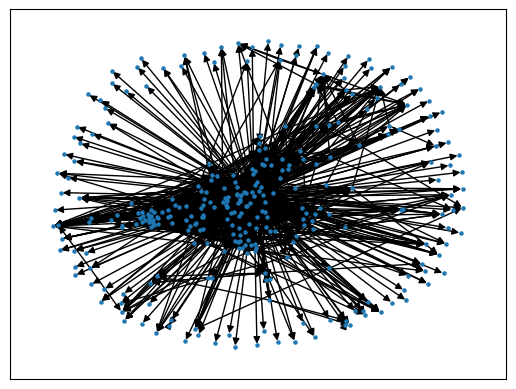

In [71]:
nx.draw_networkx(graph_woman, with_labels = False, node_size = 5)

In [46]:
print(f"number of nodes: {graph_woman.number_of_nodes()}")
print(f"number of edges: {graph_woman.number_of_edges()}")

number of nodes: 307
number of edges: 1324


In [40]:
#Degree scores
top_degree_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_woman

Top degree scores:


{'http://dbpedia.org/resource/Woman': 1.0424836601,
 "http://dbpedia.org/resource/Women's_rights": 0.1568627451,
 'http://dbpedia.org/resource/Violence_against_women': 0.1470588235,
 'http://dbpedia.org/resource/United_Nations': 0.1209150327,
 'http://dbpedia.org/resource/Domestic_violence': 0.1111111111,
 'http://dbpedia.org/resource/Pregnancy': 0.1078431373,
 'http://dbpedia.org/resource/Sexism': 0.1045751634,
 'http://dbpedia.org/resource/Sexual_intercourse': 0.1013071895,
 'http://dbpedia.org/resource/Christianity': 0.091503268,
 'http://dbpedia.org/resource/Marriage': 0.091503268}

In [38]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_woman

Top betweeness scores:


{'http://dbpedia.org/resource/Woman': 0.4596099525,
 'http://dbpedia.org/resource/Pregnancy': 0.175512033,
 'http://dbpedia.org/resource/Human': 0.1058629313,
 'http://dbpedia.org/resource/Burqa': 0.0521289051,
 'http://dbpedia.org/resource/Menstruation': 0.0497830794,
 'http://dbpedia.org/resource/Judaism': 0.0455670271,
 'http://dbpedia.org/resource/Afghanistan': 0.0440592264,
 'http://dbpedia.org/resource/Christianity': 0.0295655318,
 'http://dbpedia.org/resource/France': 0.0287771924,
 'http://dbpedia.org/resource/Misogyny': 0.0260442497}

In [84]:
top_prestige_scores_woman = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_woman).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_woman

Top prestige scores:


{'http://dbpedia.org/resource/Saudi_Arabia': 0.2148558275,
 'http://dbpedia.org/resource/United_Nations': 0.2121224368,
 'http://dbpedia.org/resource/Christianity': 0.2064007771,
 'http://dbpedia.org/resource/Pregnancy': 0.2037814779,
 'http://dbpedia.org/resource/Judaism': 0.2022415675,
 'http://dbpedia.org/resource/Pew_Research_Center': 0.2019933607,
 'http://dbpedia.org/resource/Menstruation': 0.188473949,
 'http://dbpedia.org/resource/Woman': 0.1871559494,
 'http://dbpedia.org/resource/Reproductive_health': 0.1865171852,
 'http://dbpedia.org/resource/Puberty': 0.184151152}

## Male

In [51]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % male_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_male = sparql.query().convert()

# Create an empty directed graph
graph_male = nx.DiGraph()

# Add 'Man' page to the graph
graph_male.add_node(male_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_male["results"]["bindings"]:
    link = result["link"]["value"]
    graph_male.add_edge(male_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_male = sparql.query().convert()

    # Add the linked page to the graph
    graph_male.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_male["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_male.nodes():
            graph_male.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

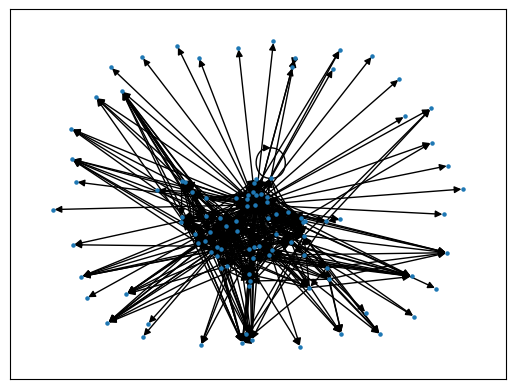

In [72]:
nx.draw_networkx(graph_male, with_labels = False, node_size = 5)

In [53]:
print(f"number of nodes: {graph_male.number_of_nodes()}")
print(f"number of edges: {graph_male.number_of_edges()}")

number of nodes: 102
number of edges: 468


In [52]:
#Degree scores
top_degree_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_male

Top degree scores:


{'http://dbpedia.org/resource/Male': 1.2178217822,
 'http://dbpedia.org/resource/Sex': 0.3663366337,
 'http://dbpedia.org/resource/Female': 0.2475247525,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2277227723,
 'http://dbpedia.org/resource/Gamete': 0.2178217822,
 'http://dbpedia.org/resource/Insect': 0.2178217822,
 'http://dbpedia.org/resource/Animal': 0.1782178218,
 'http://dbpedia.org/resource/Hermaphrodite': 0.1782178218,
 'http://dbpedia.org/resource/Mammal': 0.1683168317,
 'http://dbpedia.org/resource/Chromosome': 0.1683168317}

In [54]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_male

Top betweeness scores:


{'http://dbpedia.org/resource/Male': 0.4633825936,
 'http://dbpedia.org/resource/Bird': 0.0667946723,
 'http://dbpedia.org/resource/Gamete': 0.0587463246,
 'http://dbpedia.org/resource/Sex-determination_system': 0.0271594999,
 'http://dbpedia.org/resource/Female': 0.021470906,
 'http://dbpedia.org/resource/Anisogamy': 0.0205486781,
 'http://dbpedia.org/resource/Convergent_evolution': 0.019515323,
 'http://dbpedia.org/resource/Mars_(mythology)': 0.0194059406,
 'http://dbpedia.org/resource/Gender': 0.0193069307,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.0192342216}

In [83]:
top_prestige_scores_male = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_male).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_male

Top prestige scores:


{'http://dbpedia.org/resource/Carl_Linnaeus': 0.3257177871,
 'http://dbpedia.org/resource/Male': 0.3185294118,
 'http://dbpedia.org/resource/Gamete': 0.2895721925,
 'http://dbpedia.org/resource/Human': 0.2893016856,
 'http://dbpedia.org/resource/Bee': 0.2820450494,
 'http://dbpedia.org/resource/Bird': 0.2794117647,
 'http://dbpedia.org/resource/Fertilization': 0.2681332696,
 'http://dbpedia.org/resource/Anisogamy': 0.2676717746,
 'http://dbpedia.org/resource/Hymenoptera': 0.2659709045,
 'http://dbpedia.org/resource/Animal': 0.2589670014}

## Female

In [59]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % female_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_female = sparql.query().convert()

# Create an empty directed graph
graph_female = nx.DiGraph()

# Add 'Man' page to the graph
graph_female.add_node(female_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_female["results"]["bindings"]:
    link = result["link"]["value"]
    graph_female.add_edge(female_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_female = sparql.query().convert()

    # Add the linked page to the graph
    graph_female.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_female["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_female.nodes():
            graph_female.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

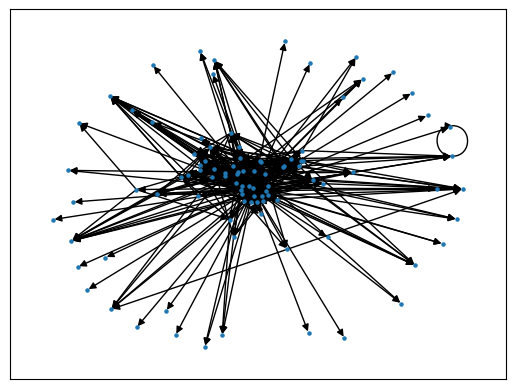

In [73]:
nx.draw_networkx(graph_female, with_labels = False, node_size = 5)

In [60]:
print(f"number of nodes: {graph_female.number_of_nodes()}")
print(f"number of edges: {graph_female.number_of_edges()}")

number of nodes: 96
number of edges: 411


In [61]:
#Degree scores
top_degree_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_female

Top degree scores:


{'http://dbpedia.org/resource/Female': 1.2736842105,
 'http://dbpedia.org/resource/Male': 0.4,
 'http://dbpedia.org/resource/Sex': 0.3157894737,
 'http://dbpedia.org/resource/Gamete': 0.2526315789,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2421052632,
 'http://dbpedia.org/resource/Chromosome': 0.2,
 'http://dbpedia.org/resource/XY_sex-determination_system': 0.2,
 'http://dbpedia.org/resource/Y_chromosome': 0.1894736842,
 'http://dbpedia.org/resource/Mammal': 0.1789473684,
 'http://dbpedia.org/resource/Hermaphrodite': 0.1789473684}

In [62]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_female

Top betweeness scores:


{'http://dbpedia.org/resource/Female': 0.4855586015,
 'http://dbpedia.org/resource/Gamete': 0.0764984794,
 'http://dbpedia.org/resource/Sex-determination_system': 0.0295486904,
 'http://dbpedia.org/resource/Reproduction': 0.0295351168,
 'http://dbpedia.org/resource/Mammal': 0.0265003054,
 'http://dbpedia.org/resource/Turner_syndrome': 0.0223564714,
 'http://dbpedia.org/resource/Anisogamy': 0.0191076862,
 'http://dbpedia.org/resource/Chromosome': 0.018943163,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.0169873548,
 'http://dbpedia.org/resource/Gonochorism': 0.0114341261}

In [82]:
top_prestige_scores_female = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_female).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_female

Top prestige scores:


{'http://dbpedia.org/resource/Female': 0.3501157407,
 'http://dbpedia.org/resource/Gamete': 0.3316885965,
 'http://dbpedia.org/resource/Human': 0.3214831804,
 'http://dbpedia.org/resource/Chromosome': 0.2944898754,
 'http://dbpedia.org/resource/Anisogamy': 0.2890863914,
 'http://dbpedia.org/resource/Monotreme': 0.2868114407,
 'http://dbpedia.org/resource/Sex-determination_system': 0.2864583333,
 'http://dbpedia.org/resource/Sexual_reproduction': 0.2838776276,
 'http://dbpedia.org/resource/Cell_(biology)': 0.2740036232,
 'http://dbpedia.org/resource/Ovum': 0.2722222222}

## Non-Binary

In [65]:
query = """
SELECT ?link
WHERE {
  <%s> dbo:wikiPageWikiLink ?link .
}
""" % non_binary_uri

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results_non_binary = sparql.query().convert()

# Create an empty directed graph
graph_non_binary = nx.DiGraph()

# Add 'Man' page to the graph
graph_non_binary.add_node(non_binary_uri)

# Iterate through the results and add nodes and edges to the graph
for result in results_non_binary["results"]["bindings"]:
    link = result["link"]["value"]
    graph_non_binary.add_edge(non_binary_uri, link)

    # Query the linked page for its outgoing links
    query_linked_page = """
    SELECT ?linkedLink
    WHERE {
      <%s> dbo:wikiPageWikiLink ?linkedLink .
    }
    """ % link

    sparql.setQuery(query_linked_page)
    sparql.setReturnFormat(JSON)

    linked_results_non_binary = sparql.query().convert()

    # Add the linked page to the graph
    graph_non_binary.add_node(link)

    # Add edges between the linked page and its outgoing links
    for linked_result in linked_results_non_binary["results"]["bindings"]:
        linked_link = linked_result["linkedLink"]["value"]
        if linked_link in graph_non_binary.nodes():
            graph_non_binary.add_edge(link, linked_link)

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

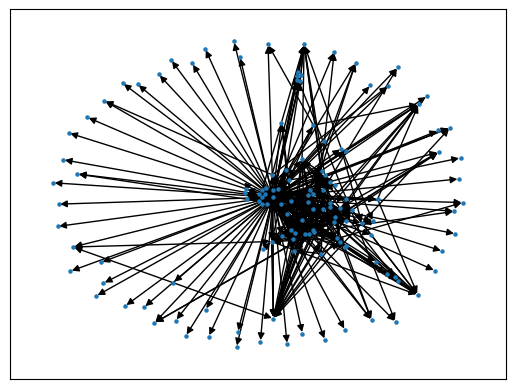

In [74]:
nx.draw_networkx(graph_non_binary, with_labels = False, node_size = 5)

In [67]:
print(f"number of nodes: {graph_non_binary.number_of_nodes()}")
print(f"number of edges: {graph_non_binary.number_of_edges()}")

number of nodes: 134
number of edges: 414


In [66]:
#Degree scores
top_degree_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores_non_binary

Top degree scores:


{'http://dbpedia.org/resource/Non-binary_gender': 1.1729323308,
 'http://dbpedia.org/resource/Transgender': 0.2105263158,
 'http://dbpedia.org/resource/Gender_identity': 0.2030075188,
 'http://dbpedia.org/resource/Intersex': 0.1578947368,
 'http://dbpedia.org/resource/Gender': 0.1503759398,
 'http://dbpedia.org/resource/Gender_binary': 0.1428571429,
 'http://dbpedia.org/resource/Third_gender': 0.1353383459,
 'http://dbpedia.org/resource/Gender_role': 0.1203007519,
 'http://dbpedia.org/resource/X-gender': 0.1203007519,
 'http://dbpedia.org/resource/Gender_expression': 0.1127819549}

In [68]:
#Betweenes scores
print("Top betweeness scores:")
top_btw_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
top_btw_scores_non_binary

Top betweeness scores:


{'http://dbpedia.org/resource/Non-binary_gender': 0.4094353012,
 'http://dbpedia.org/resource/Gender_identity': 0.0678513474,
 'http://dbpedia.org/resource/Judith_Butler': 0.0338459786,
 'http://dbpedia.org/resource/Gender_binary': 0.0288826356,
 'http://dbpedia.org/resource/Transgender': 0.0280303995,
 'http://dbpedia.org/resource/Gender-neutral_language': 0.0202067669,
 'http://dbpedia.org/resource/Gender_role': 0.0196219688,
 'http://dbpedia.org/resource/Third_gender': 0.0170283785,
 'http://dbpedia.org/resource/Transphobia': 0.0156191344,
 'http://dbpedia.org/resource/2021_Canadian_census': 0.0149806334}

In [81]:
top_prestige_scores_non_binary = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph_non_binary).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores_non_binary

Top prestige scores:


{'http://dbpedia.org/resource/Intersex': 0.2826735886,
 'http://dbpedia.org/resource/Non-binary_gender': 0.2659967489,
 'http://dbpedia.org/resource/United_States': 0.2484604947,
 'http://dbpedia.org/resource/Gender': 0.2398720682,
 'http://dbpedia.org/resource/Gender_identity': 0.2377493066,
 'http://dbpedia.org/resource/Queer': 0.2284771793,
 'http://dbpedia.org/resource/Judith_Butler': 0.2257619466,
 'http://dbpedia.org/resource/Gender_binary': 0.2202104233,
 'http://dbpedia.org/resource/Gender_expression': 0.2166586423,
 'http://dbpedia.org/resource/Intersex_Society_of_North_America': 0.2037810945}

## Merged graph

In [75]:
parql = SPARQLWrapper("http://dbpedia.org/sparql")  # DBpedia SPARQL endpoint
resource_uri = ["http://dbpedia.org/resource/Woman", 
               "http://dbpedia.org/resource/Man",
               "http://dbpedia.org/resource/Female",
               "http://dbpedia.org/resource/Male",
               "http://dbpedia.org/resource/Non-binary_gender"]  # Resource URI for 'Man' page

def get_graph_from_url(uri):
    query = """
    SELECT ?link
    WHERE {
      <%s> dbo:wikiPageWikiLink ?link .
    }
    """ % uri

    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)

    results = sparql.query().convert()

    # Create an empty directed graph
    graph = nx.DiGraph()
    
    # Add 'Man' page to the graph
    graph.add_node(uri)

    # Iterate through the results and add nodes and edges to the graph
    for result in results["results"]["bindings"]:
        link = result["link"]["value"]
        graph.add_edge(uri, link)

        # Query the linked page for its outgoing links
        query_linked_page = """
        SELECT ?linkedLink
        WHERE {
          <%s> dbo:wikiPageWikiLink ?linkedLink .
        }
        """ % link

        sparql.setQuery(query_linked_page)
        sparql.setReturnFormat(JSON)

        linked_results = sparql.query().convert()

        # Add the linked page to the graph
        graph.add_node(link)

        # Add edges between the linked page and its outgoing links
        for linked_result in linked_results["results"]["bindings"]:
            linked_link = linked_result["linkedLink"]["value"]
            if linked_link in graph.nodes():
                graph.add_edge(link, linked_link)
    return graph


# Create an empty directed graph
graph = nx.DiGraph()

for uri in resource_uri:
    tmp_graph = get_graph_from_url(uri)
    graph.add_nodes_from(tmp_graph.nodes())
    graph.add_edges_from(tmp_graph.edges())

# Print the nodes and edges of the graph
#print("Nodes:", graph.nodes())
#print("Edges:", graph.edges())

In [76]:
print(f"number of nodes: {graph.number_of_nodes()}")
print(f"number of edges: {graph.number_of_edges()}")
print("Density of the directed graph:", nx.density(graph))

number of nodes: 652
number of edges: 2719
Density of the directed graph: 0.006405906910557613


In [77]:
top_degree_scores = {id: round(btw_central,10) for id, btw_central in sorted(nx.degree_centrality(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top degree scores:")
top_degree_scores

Top degree scores:


{'http://dbpedia.org/resource/Woman': 0.4915514593,
 'http://dbpedia.org/resource/Non-binary_gender': 0.2396313364,
 'http://dbpedia.org/resource/Man': 0.2181259601,
 'http://dbpedia.org/resource/Female': 0.2150537634,
 'http://dbpedia.org/resource/Male': 0.198156682,
 "http://dbpedia.org/resource/Women's_rights": 0.0737327189,
 'http://dbpedia.org/resource/Sex': 0.0721966206,
 'http://dbpedia.org/resource/Gender_role': 0.0706605223,
 'http://dbpedia.org/resource/Violence_against_women': 0.069124424,
 'http://dbpedia.org/resource/Human': 0.0675883257}

In [79]:
top_btw_scores = {id: round(btw_central,10) for id, btw_central in sorted(nx.betweenness_centrality(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top betweeness scores:")
top_btw_scores

Top betweeness scores:


{'http://dbpedia.org/resource/Woman': 0.275038311,
 'http://dbpedia.org/resource/Female': 0.1323029026,
 'http://dbpedia.org/resource/Non-binary_gender': 0.1207312208,
 'http://dbpedia.org/resource/Man': 0.1081090779,
 'http://dbpedia.org/resource/Human': 0.0970292039,
 'http://dbpedia.org/resource/Pregnancy': 0.0842047775,
 'http://dbpedia.org/resource/Gender_identity': 0.0641394272,
 'http://dbpedia.org/resource/Gender_role': 0.0626526518,
 'http://dbpedia.org/resource/Male': 0.0550094724,
 'http://dbpedia.org/resource/Menstruation': 0.0234746738}

In [80]:
top_prestige_scores = {id: round(btw_central,10) for id, btw_central in sorted(proximity_prestige(graph).items(), key=lambda item: item[1], reverse=True)[:10]}
print("Top prestige scores:")
top_prestige_scores

Top prestige scores:


{'http://dbpedia.org/resource/Human': 0.1864113168,
 'http://dbpedia.org/resource/Puberty': 0.1862035004,
 'http://dbpedia.org/resource/Woman': 0.1843537968,
 'http://dbpedia.org/resource/Female': 0.1805670701,
 'http://dbpedia.org/resource/Pregnancy': 0.1774968543,
 'http://dbpedia.org/resource/Judaism': 0.1743471189,
 'http://dbpedia.org/resource/Saudi_Arabia': 0.1741676097,
 'http://dbpedia.org/resource/Gender_identity': 0.1736221828,
 'http://dbpedia.org/resource/Man': 0.1732619708,
 'http://dbpedia.org/resource/Intersex': 0.1653708316}

### Divisive Clustering - 5 clusters

In [86]:
graph_undir = graph.to_undirected()
# Divisive Clustering based on Edge Betweenness
clustered = graph_undir.copy()

while(True):
    # Identify "weakest" edge
    top_betweeness_edge_score = sorted(nx.edge_betweenness_centrality(clustered).items(), key=lambda item: item[1], reverse=True)[0]
    top_betweeness_edge = top_betweeness_edge_score[0]
    
    # Remove edge
    clustered.remove_edge(top_betweeness_edge[0], top_betweeness_edge[1])
    
    # Stop removing edges as soon as the graph is split into three components.
    if nx.number_connected_components(clustered) == 5:
        break

print('Number of components: {}'.format(nx.number_connected_components(clustered)))

Number of components: 5


Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Sexual_intercourse
	 http://dbpedia.org/resource/Violence_against_women
	 http://dbpedia.org/resource/Woman
	 http://dbpedia.org/resource/Women's_rights
	 http://dbpedia.org/resource/Pregnancy
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Female
	 http://dbpedia.org/resource/Mammal
	 http://dbpedia.org/resource/XY_sex-determination_system
	 http://dbpedia.org/resource/Sex
	 http://dbpedia.org/resource/Male
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Reproductive_system
	 http://dbpedia.org/resource/Semen
	 http://dbpedia.org/resource/Prostate
	 http://dbpedia.org/resource/Human_penis
	 http://dbpedia.org/resource/Man
Pages with the highest betweeness scores of the component: 
	 http://dbpedia.org/resource/Intersex
	 http://dbpedia.org/resource/Gender
	 http://dbpedia.org/resource/Gender_identity
	 http://dbpe

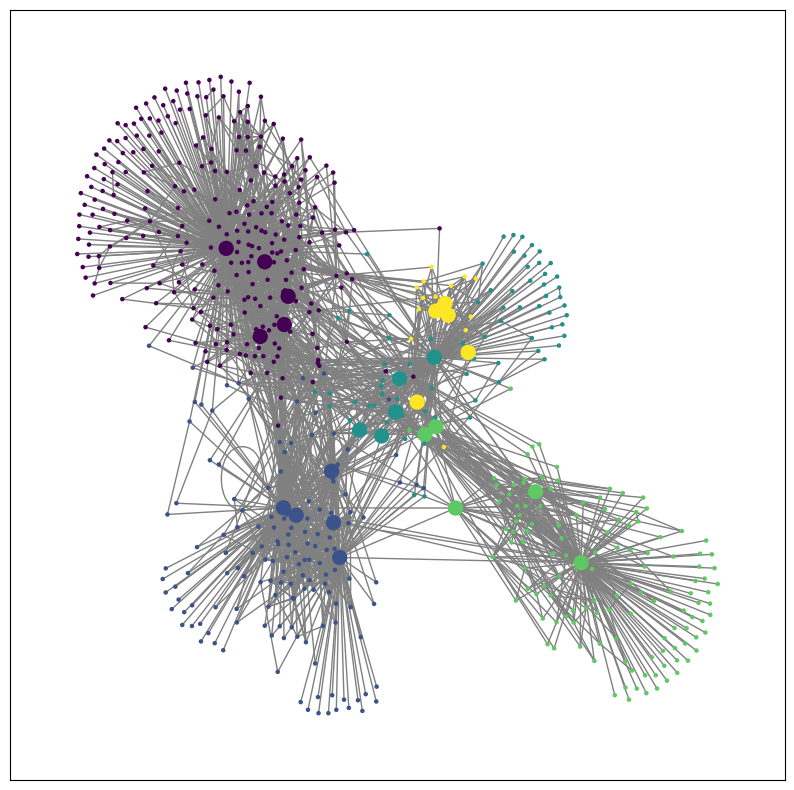

In [95]:
# Initialize label, color and size dict for visualizing the graphs
node_label_dict = {v: '' for v in graph_undir.nodes()}
node_color_dict = {v:5 for v in graph_undir.nodes()}
node_size_dict = {v:5 for v in graph_undir.nodes()}

pos = nx.spring_layout(graph_undir, scale=5, seed=42)
current_color = 0
for component in nx.connected_components(clustered):
    # Change color of nodes with this component
    current_color += 100
    print('Pages with the highest betweeness scores of the component: ')
    # Determine subgraph of component and determine stops with the highest betweeness scores
    component_graph = clustered.copy()
    component_graph.remove_nodes_from([n for n in component_graph if n not in set(component)])
    top_betweeness_score_pages = [k for k,v in 
                                  sorted(nx.betweenness_centrality(component_graph, normalized =True).items(), 
                                         key=lambda item: item[1], reverse=True)[:5]]

    for node in component:
        # Add node color and size
        node_color_dict[node] = current_color

        if node in top_betweeness_score_pages:
            print('\t {}'.format(node))
            # Add node label and size for the visualization
            node_label_dict[node] = node
            node_size_dict[node] = 100

# Set node size and color of the output network
node_size = [node_size_dict[v] for v in graph_undir.nodes()]
node_color = [node_color_dict[v] for v in graph_undir.nodes()]

# Draw the network
plt.figure(figsize=(10,10))
nx.draw_networkx(graph_undir, pos=pos, with_labels=False,
                 node_color=node_color,
                 node_size=node_size, labels=node_label_dict
                ,edge_color='grey')

plt.show()